<a id='content'></a>
# Оглавление
* [Описание проекта](#description)
* [Шаг 1. Откройте файл с данными и изучите общую информацию](#download)
* [Шаг 2. Предобработка данных](#preprocessing)
* [Шаг 3. Изучите и проверьте данные](#research)
* [Шаг 4. Изучите воронку событий](#test)
* [Шаг 5. Изучите результаты эксперимента](#experience)
* [Вывод](#results)

# Описание проекта

<a id='description'></a>
[К оглавлению](#content)

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.


Цель работы:

изучить воронку продаж,

исследовать результаты А/А/В-эксперимента,

проверить статистические критерии на разницу между выборками 246 и 247, и 246+247 и 248.

### Шаг 1. Откройте файл с данными и изучите общую информацию.

<a id='download'></a>
[К оглавлению](#content)

In [3]:
# загрузка нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import datetime as dt
from scipy import stats as st
import math as mth
import matplotlib.dates as mdates

#!pip install plotly==5.0.0
from plotly import graph_objects as go
import plotly.graph_objects as go

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [4]:
# загрузка данных
try: # Обезопасим себя))
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('logs_exp.csv', sep='\t')

In [5]:
for df in [(logs,'logs_exp')]:
    display('_________________________________________________')
    display('_________________________________________________')
    print('\033[1m' + df[1] + '\033[0m')
    display(df[0].info(), df[0].head(10),
            pd.DataFrame(round((df[0].isna().mean() *100),2)).style.background_gradient(cmap='coolwarm'))
    print('\033[1m' + 'Количество дубликатов:'+ '\033[0m', df[0].duplicated().sum())
    
# Посмотрим на общую информацию и на процентное содержание пропусков.

'_________________________________________________'

'_________________________________________________'

logs_exp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


,0
EventName,0
DeviceIDHash,0
EventTimestamp,0
ExpId,0


Количество дубликатов: 413


Каждая строчка таблицы содержит действие пользователя мобильного приложения. Есть 413 дубликатов. Это меньше 1% всех данных, поэтому просто удалим их.

EventTimestamp переведем в datetime

Возможно, телефон пользователя отправлял одновременно один и тот же запрос на сервер несколько раз

### Шаг 2. Предобработка данных

<a id='preprocessing'></a>
[К оглавлению](#content)

__Замените названия столбцов на удобные для вас__

In [6]:
logs = logs.rename(columns={"EventName": "name", "DeviceIDHash": "device_id", "EventTimestamp": "time", "ExpId": "exp_id"})
logs.head()

,name,device_id,time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


__Проверьте пропуски и типы данных. Откорректируйте, если нужно__

In [7]:
logs['time'] = pd.to_datetime(logs['time'], unit='s') # Переведем в datetime
logs.info()
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
name         244126 non-null object
device_id    244126 non-null int64
time         244126 non-null datetime64[ns]
exp_id       244126 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


,name,device_id,time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


__Добавьте столбец даты и времени, а также отдельный столбец дат__

In [8]:
logs['date'] = pd.to_datetime(logs['time'].dt.date)
logs.head()

,name,device_id,time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


__Удалим дубликаты__

In [9]:
logs = logs.drop_duplicates().reset_index(drop = True)

In [10]:
logs.duplicated().sum() # Проверка

0

### Шаг 3. Изучите и проверьте данные

<a id='research'></a>
[К оглавлению](#content)

__Сколько всего событий в логе?__

__Сколько всего пользователей в логе?__

__Сколько в среднем событий приходится на пользователя?__

In [11]:
print('Событий в логе:', len(logs))

Событий в логе: 243713


In [12]:
print('Всего пользователей в логе:', len(logs['device_id'].unique()))

Всего пользователей в логе: 7551


In [13]:
# Посчитаем моду событий, самое часто встречающиеся количество событий на одного пользователя
print('Мода событий на пользователя:', logs['device_id'].value_counts().mode()[0])

Мода событий на пользователя: 5


In [14]:
logs['device_id'].value_counts().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: device_id, dtype: float64

Мы имеем большое стандартное отклонение, что говорит о недоверии к mean. А мода покажет наиболее часто встречающееся значение, что идеально для нашего мобильного приложения.

__Максимальная и минмальная даты в данных__

In [15]:
logs['time'].min()

Timestamp('2019-07-25 04:43:36')

In [16]:
logs['time'].max()

Timestamp('2019-08-07 21:15:17')

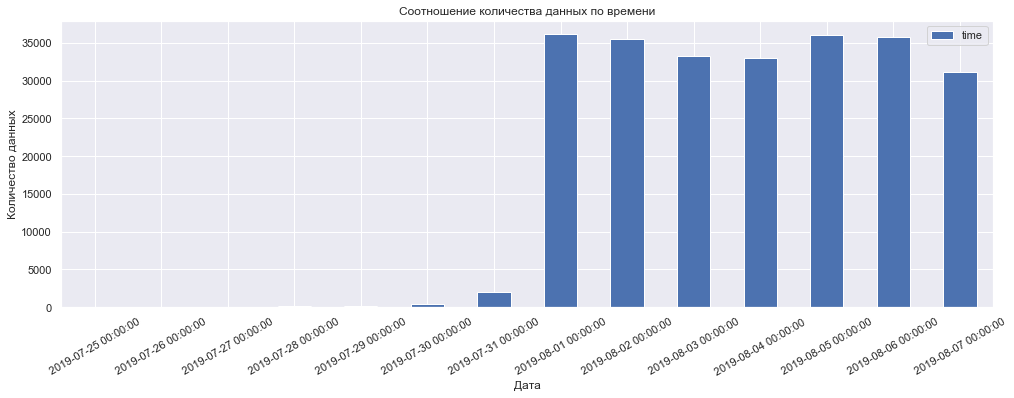

In [17]:
event_date_grouped = logs.groupby('date', as_index=False).agg({'time':'count'})
sns.set(rc={'figure.figsize':(16.7,5.27)})
event_date_grouped.plot(kind='bar', x = 'date', y='time')

plt.xticks(rotation=30)
plt.title('Соотношение количества данных по времени')
plt.xlabel('Дата')
plt.ylabel('Количество данных')
plt.show()

По графику видно, что полные данные начинаются с 01.08.2019 до 07.08.2019. Отбросим более старые данные до 1 августа 2019 г.

In [18]:
new = logs.query('time >= "2019-08-01"')
new.head()

,name,device_id,time,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Число строк до данной даты у нас незначительное.

In [19]:
print('Событий в новом логе:', len(new))
print('Всего пользователей в новом логе:', len(new['device_id'].unique()))

Событий в новом логе: 240887
Всего пользователей в новом логе: 7534


In [20]:
print('Событий в изначальном логе:', len(logs))
print('Всего пользователей в изначальном логе:', len(logs['device_id'].unique()))

Событий в изначальном логе: 243713
Всего пользователей в изначальном логе: 7551


Отбросили 2826 событий и 17 пользователей

In [21]:
new['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Мы имеем все три группы А\А\В теста

Не слишком много данных удалено.

### Шаг 4. Изучите воронку событий

<a id='test'></a>
[К оглавлению](#content)

__Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.__

In [22]:
new.head()

,name,device_id,time,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: name, dtype: int64

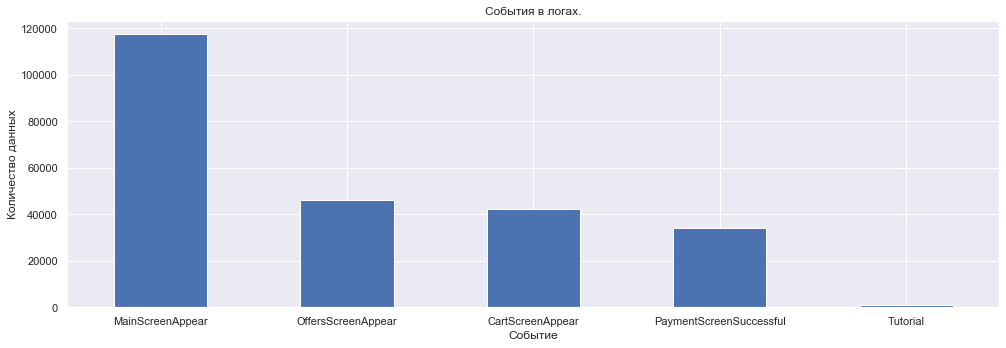

In [23]:
cc = new['name'].value_counts()
display(cc)

cc.plot.bar(title="События в логах.")

plt.xticks(rotation=360)
plt.xlabel('Событие')
plt.ylabel('Количество данных')

plt.show()

Самое популярное событие в приложении это MainScreenAppear

__Посчитайте, сколько пользователей совершали каждое из этих событий. Посчитайте долю пользователей, которые хоть раз совершали событие.__

In [24]:
for c in ['MainScreenAppear','OffersScreenAppear', 'CartScreenAppear','PaymentScreenSuccessful', 'Tutorial']:
    display('_________________________________________________')
    print('\033[1m' + c + '\033[0m')
    cc = new.query('name == @c')
    n = np.unique(cc['device_id'])
    nn = np.count_nonzero(n)
    #cc = (new[new['name'] == c].count())
    #n = cc['device_id']
    display(nn)

'_________________________________________________'

MainScreenAppear


7419

'_________________________________________________'

OffersScreenAppear


4593

'_________________________________________________'

CartScreenAppear


3734

'_________________________________________________'

PaymentScreenSuccessful


3539

'_________________________________________________'

Tutorial


840

In [25]:
users_count = new.groupby('name').agg({'device_id': 'nunique'})
users_count_ = users_count.sort_values(by='device_id', ascending=False)
print(users_count_)
print('Доля тех, кто хоть раз совершал событие:', 3539 / 7534)

                         device_id
name                              
MainScreenAppear              7419
OffersScreenAppear            4593
CartScreenAppear              3734
PaymentScreenSuccessful       3539
Tutorial                       840
Доля тех, кто хоть раз совершал событие: 0.4697371913989912


Название Tutorial говорит о прохождении обучения по работе с приложением, его можно убрать из анализа. В итоге 3539 пользователей хоть раз совершали событие. Это 47% от всех пользователей.

In [26]:
for c in [('MainScreenAppear' , 7419), ('OffersScreenAppear', 4593), ('CartScreenAppear', 3734), ('PaymentScreenSuccessful', 3539)]:
    display('_________________________________________________')
    print('\033[1m' + 'Доля пользователей, дошедших до', c[0] + '\033[0m')
    cc = c[1] / 7534
    display('{:,.2%}'.format(cc))

'_________________________________________________'

Доля пользователей, дошедших до MainScreenAppear


'98.47%'

'_________________________________________________'

Доля пользователей, дошедших до OffersScreenAppear


'60.96%'

'_________________________________________________'

Доля пользователей, дошедших до CartScreenAppear


'49.56%'

'_________________________________________________'

Доля пользователей, дошедших до PaymentScreenSuccessful


'46.97%'

На шаге MainScreenAppear  в  OffersScreenAppear мы теряем 38% пользователей

__По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.__

In [27]:
users_count = users_count.sort_values(['device_id'], ascending=False)

In [28]:
users_count = users_count[:-1]
users_count

,device_id
name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [29]:
users_count['GrowthRate'] = (users_count.iloc[:, 0].div(users_count.iloc[:, 0].shift())
                    .fillna(0).replace([np.inf, -np.inf], 0))
display(users_count)
print('_____________________________________________________________________________')
print('Доля пользователей доходит от первого события до оплаты:', 3539 / 7534)

,device_id,GrowthRate
name,,
MainScreenAppear,7419,0.000000
OffersScreenAppear,4593,0.619086
CartScreenAppear,3734,0.812976
PaymentScreenSuccessful,3539,0.947777


_____________________________________________________________________________
Доля пользователей доходит от первого события до оплаты: 0.4697371913989912


In [45]:
fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [7419, 4593, 3734, 3539], textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))

fig.update_layout(title_text="Воронка пользователей от MainScreenAppear до PaymentScreenSuccessful")

fig.show()

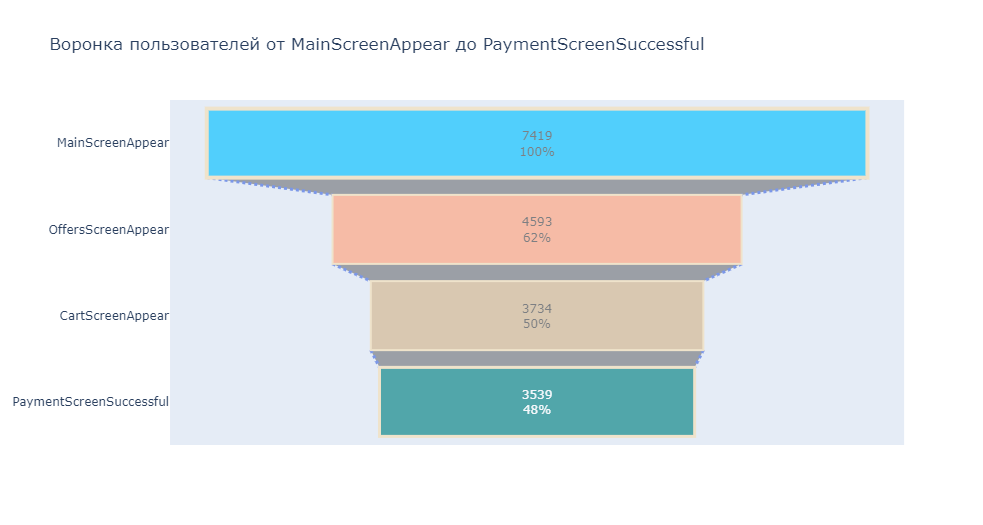

На шаге "появление главного экрана" - "предложение о товаре" теряется больше всего пользователей.

### Шаг 5. Изучите результаты эксперимента

<a id='experience'></a>
[К оглавлению](#content)

__Сколько пользователей в каждой экспериментальной группе?__

In [32]:
for c in [(246 , '246'), (247, '247'), (248, '248')]:
    display('_________________________________________________')
    print('\033[1m' + 'Экспериментальная группа', c[1] + '\033[0m')
    cc = new.query('exp_id == @c[0]')
    n = np.unique(cc['device_id'])
    nn = np.count_nonzero(n)
    display(nn)

'_________________________________________________'

Экспериментальная группа 246


2484

'_________________________________________________'

Экспериментальная группа 247


2513

'_________________________________________________'

Экспериментальная группа 248


2537

Больше всего пользователей в Экспериментальная группа 248

Размеры групп несколько различаются. Это говорит нам о неоптимальности разбиения данных по группам. Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению.

__Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.__

Самое популярное событие - MainScreenAppear

In [33]:
def Z_test(exp_id1, exp_id2, name1, part_2, number_1, number_2):
    new6 = new.query('exp_id == exp_id1')
    new246 = new.query('exp_id == exp_id1 & name == "name1"')

    new7 = new.query('exp_id == exp_id2')
    new247 = new.query('exp_id == exp_id2 & name == "name1"')

    print('Всего пользователей в группе:', len(new6['device_id'].unique()))
    print('Всего пользователей в группе с событием MainScreenAppear:', len(new246['device_id'].unique()))
    print('________________________________________________________________')
    print('Всего пользователей в группе:', len(new7['device_id'].unique()))
    print('Всего пользователей в группе с событием MainScreenAppear:', len(new247['device_id'].unique()))

In [34]:
new6 = new.query('exp_id == 246')
new246 = new.query('exp_id == 246 & name == "MainScreenAppear"')

new7 = new.query('exp_id == 247')
new247 = new.query('exp_id == 247 & name == "MainScreenAppear"')

print('Всего пользователей в группе 246:', len(new6['device_id'].unique()))
print('Всего пользователей в группе 246 с событием MainScreenAppear:', len(new246['device_id'].unique()))
print('________________________________________________________________')
print('Всего пользователей в группе 247:', len(new7['device_id'].unique()))
print('Всего пользователей в группе 247 с событием MainScreenAppear:', len(new247['device_id'].unique()))

Всего пользователей в группе 246: 2484
Всего пользователей в группе 246 с событием MainScreenAppear: 2450
________________________________________________________________
Всего пользователей в группе 247: 2513
Всего пользователей в группе 247 с событием MainScreenAppear: 2476


H0: "Между конверсиями в группах а и б нет статистически значимых различий"

H1: "Различия между конверсиями в группах а и б статистически значимы"

In [35]:
def Z_test(exp_id1, exp_id2, name1):
    new6 = new.query('exp_id == @exp_id1')
    new246 = new.query('exp_id == @exp_id1 & name == @name1')

    new7 = new.query('exp_id == @exp_id2')
    new247 = new.query('exp_id == @exp_id2 & name == @name1')
    
    new246_ = len(new246['device_id'].unique())
    new6_ = len(new6['device_id'].unique())
    new247_ = len(new247['device_id'].unique())
    new7_ = len(new7['device_id'].unique())
    
    print('\033[1m' + name1 + '\033[0m')

    print('Всего пользователей в группе', exp_id1, ':', len(new6['device_id'].unique()))
    print('Всего пользователей в группе с событием', exp_id1, ':', len(new246['device_id'].unique()))
    print('________________________________________________________________')
    print('Всего пользователей в группе:', exp_id2, ':', len(new7['device_id'].unique()))
    print('Всего пользователей в группе с событием', exp_id2, ':', len(new247['device_id'].unique()))

    alpha = .003 # критический уровень статистической значимости

    successes = np.array([new246_, new247_])
    trials = np.array([new6_, new7_])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Ранее мы выяснили, что проход по всем этапам воронки не является обязательным, так что работать нужно именно относительно общего числа клиентов. 

In [36]:
Z_test(246, 247, "MainScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 247, "OffersScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 247, "CartScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 247, "PaymentScreenSuccessful")

MainScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 2450
________________________________________________________________
Всего пользователей в группе: 247 : 2513
Всего пользователей в группе с событием 247 : 2476
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

OffersScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1542
________________________________________________________________
Всего пользователей в группе: 247 : 2513
Всего пользователей в группе с событием 247 : 1520
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

CartScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1266
________________________________________________________________
Всего пользователей в группе: 247 : 2513
Всего пользователей в группе с событием 247 : 1238
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

PaymentScreenSuccessful
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1200
________________________________________________________________
Всего пользователей в группе: 247 : 2513
Всего пользователей в группе с событием 247 : 1158
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех событий группы АА нет оснований считать доли разными. Разбиение на группы работает корректно.

__Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Какие выводы из эксперимента можно сделать?__

In [37]:
Z_test(246, 248, "MainScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 248, "OffersScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 248, "CartScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(246, 248, "PaymentScreenSuccessful")

MainScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 2450
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 2493
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

OffersScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1542
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1531
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

CartScreenAppear
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1266
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1230
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

PaymentScreenSuccessful
Всего пользователей в группе 246 : 2484
Всего пользователей в группе с событием 246 : 1200
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1181
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех событий группы 246 и 248 нет оснований считать доли разными. Разбиение на группы работает корректно.

In [38]:
Z_test(247, 248, "MainScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(247, 248, "OffersScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(247, 248, "CartScreenAppear")
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test(247, 248, "PaymentScreenSuccessful")

MainScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 2476
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 2493
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

OffersScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1520
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1531
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

CartScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1238
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1230
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

PaymentScreenSuccessful
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1158
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1181
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех событий группы 247 и 248 нет оснований считать доли разными. Разбиение на группы работает корректно.

__Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?__

In [39]:
def Z_test1(exp_id1, exp_id2, name1, exp_idA):
    new6 = new.query('exp_id == @exp_id1')
    new246 = new.query('exp_id == @exp_id1 & name == @name1')
    
    newA = new.query('exp_id == @exp_idA')
    newAA = new.query('exp_id == @exp_idA & name == @name1')

    new7 = new.query('exp_id == @exp_id2')
    new247 = new.query('exp_id == @exp_id2 & name == @name1')
    
    new246_ = len(new246['device_id'].unique()) + len(newAA['device_id'].unique())
    new6_ = len(new6['device_id'].unique()) + len(newA['device_id'].unique())
    new247_ = len(new247['device_id'].unique())
    new7_ = len(new7['device_id'].unique())
    
    print('\033[1m' + name1 + '\033[0m')

    print('Всего пользователей в группе', exp_id1, ':', len(new6['device_id'].unique()))
    print('Всего пользователей в группе с событием', exp_id1, ':', len(new246['device_id'].unique()))
    print('________________________________________________________________')
    print('Всего пользователей в группе:', exp_id2, ':', len(new7['device_id'].unique()))
    print('Всего пользователей в группе с событием', exp_id2, ':', len(new247['device_id'].unique()))

    alpha = .003 # критический уровень статистической значимости

    successes = np.array([new246_, new247_])
    trials = np.array([new6_, new7_])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [40]:
Z_test1(247, 248, "MainScreenAppear", 246)
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test1(247, 248, "OffersScreenAppear", 246)
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test1(247, 248, "CartScreenAppear", 246)
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
display('------------------------------------------------------------------------')
Z_test1(247, 248, "PaymentScreenSuccessful", 246)

MainScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 2476
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 2493
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

OffersScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1520
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1531
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

CartScreenAppear
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1238
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1230
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

'------------------------------------------------------------------------'

PaymentScreenSuccessful
Всего пользователей в группе 247 : 2513
Всего пользователей в группе с событием 247 : 1158
________________________________________________________________
Всего пользователей в группе: 248 : 2537
Всего пользователей в группе с событием 248 : 1181
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для всех событий суммы групп 247 и 246 и группы 248 нет оснований считать доли разными. Разбиение на группы работает корректно.

__Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.__

В случае, когда на одних и тех же данных тестируется несколько гипотез (проводится несколько тестов), лучше проводить коррекцию уровня значимости. Один из вариантов это сделать - поправка Бонферрони.  Это связано с тем, что чем больше ты пытаешься найти значимый эффект, тем больше вероятность его обнаружить просто по чистой случайности.
Поскольку все данные одинаковые, то делить уровень значимости нужно на 16 = 0.003.    

### Вывод

<a id='results'></a>
[К оглавлению](#content)

Всего событий в логе 243713

Всего пользователей в логе 7551

В среднем 5 событий приходится на пользователя

Полные данные начинаются с 01.08.2019 до 07.08.2019

Самое популярное событие в приложении это MainScreenAppear

Доля пользователей доходит от первого события до оплаты: 47.7%

На шаге "появление главного экрана" - "предложение о товаре" теряется больше всего пользователей.246

В группе 246 - 79302 пользователя, в 247 - 77022, в 248 - 84563

Статистические критерии не находят разницу между выборками 246 и 247, 246+247 и 248

В стат. тестах мы не получили существенных различий между группами А и В нет, то изменение шрифта во всём приложении не вляиет на покупки пользователей мобильного приложения.